In [171]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [172]:
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.cluster import KMeans

#others
from xgboost import XGBRegressor
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import time
import xarray as xr
import sherpa
import time
from scipy.spatial import Delaunay
from scipy import interpolate
from copy import deepcopy

# enable autoreload
%load_ext autoreload
%autoreload 2
# Variables from config file
from config import BASE_DIR, FILE_NAMES, LABELS, ATTRIBUTES, BEST_MODEL_COLUMNS, ISLAND_RANGES
from math import pi as PI

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Train site-specific Linear Regression and compare the results with single-model XGBoost.

Input lables to use: Single observation from the closest observation, with lat, lon, seasonality, and elevation

In [176]:
columns = deepcopy(LABELS)
columns.extend(["season_wet", "elevation", "lat", "lon"])
for item in columns:
    print(item, end=' ')

# load datasets
df_train = pd.read_csv(f"{BASE_DIR}/train.csv", usecols=columns + ['year', 'month', 'skn', 'data_in'])
df_valid = pd.read_csv(f"{BASE_DIR}/valid.csv", usecols=columns + ['year', 'month', 'skn', 'data_in'])
df_test = pd.read_csv(f"{BASE_DIR}/test.csv", usecols=columns + ['year', 'month', 'skn', 'data_in'])
df_combined = pd.concat([df_train, df_valid, df_test])

air2m air1000_500 hgt500 hgt1000 omega500 pottemp1000-500 pottemp1000-850 pr_wtr shum-uwnd-700 shum-uwnd-925 shum-vwnd-700 shum-vwnd-950 shum700 shum925 skt slp season_wet elevation lat lon 

### Assign chrono-split index to each data: `n_folds = 5`

In [177]:
n_folds = 5

df_len_by_month = pd.DataFrame(df_combined.groupby(by=["year", "month"]).size()).reset_index().rename({0:"len"}, axis=1)
df_len_by_month['cumsum'] = df_len_by_month['len'].cumsum()

n_samples_total = df_len_by_month['cumsum'].iloc[-1]
n_samples_per_fold = np.ceil(n_samples_total / n_folds)

df_len_by_month['fold'] = df_len_by_month.apply(lambda row: int(row['cumsum'] / n_samples_per_fold), axis=1)

print("The numbers of examples in each fold")
for fold in range(5):
    print(df_len_by_month[df_len_by_month['fold'] == fold]['len'].sum())
    
df_combined = pd.merge(left=df_combined, right=df_len_by_month, left_on=["year", "month"], right_on=["year", "month"])

The numbers of examples in each fold
172693
172475
173153
174015
173225


In [157]:
# WARNING! DO NOT RUN THIS CELL OR YOU WILL HAVE TO RE-RUN THE WHOLE EXPERIMENT IN THIS NOTEBOOK!
if False: # ARE YOU SURE?
    df_result = df_combined.drop(columns=columns).drop(columns=["cumsum", "len"])
    df_result.to_csv(f"{BASE_DIR}/SiteSpecific/result.csv", index=False)

## 1. No chrono-split

In [162]:
num_groups = df_combined['skn'].unique().shape[0]
df_result = []
for i, (skn, group) in enumerate(df_combined.groupby("skn")):# iterate the group object
    if group.shape[0] < 5: continue
    # Randomize the order: this causes high variance in performance
    group = group.sample(frac=1)
    group = group[columns]
    
    Y = np.array(group["data_in"])
    X = np.array(group.drop(["data_in"], axis=1))
    
    y_pred = cross_val_predict(LinearRegression(), X, Y, cv=5, n_jobs=-1)
    
    group["prediction_multi_linear"] = y_pred
    df_result.append(group)
    
    # print out the progress
    print(f"{i}/{num_groups}", end="\r")
print()

df_result = pd.concat(df_result)

rmse_multi_linear = mean_squared_error(df_result['data_in'], df_result['prediction_multi_linear'], squared=False)
print("RMSE with site-specific linear regression: {:.3f}".format(rmse_multi_linear))

1991/1992


In [50]:
# xgb
xgboost = XGBRegressor(
    n_estimators=280,
    learning_rate=0.1,
    max_depth=9,
    verbosity=0
)

Xtrain = np.array(df_train[columns].drop(["data_in"], axis=1))
Ytrain = np.array(df_train["data_in"])

Xtest = np.array(df_test[columns].drop(["data_in"], axis=1))
Ytest = np.array(df_test["data_in"])

xgboost.fit(Xtrain, Ytrain)
yhat = xgboost.predict(Xtest)
rmse_single_xgb = mean_squared_error(Ytest, yhat, squared=False)
print("RMSE with single xgboost regression: {:.3f}".format(rmse_single_xgb))

RMSE with single xgboost regression: 4.018


## 1.1 Apply chrono split

In [159]:
num_groups = df_combined['skn'].unique().shape[0]
df_result = []
for i, (skn, group) in enumerate(df_combined.groupby("skn")):# iterate the group object
    if group.shape[0] < 5: 
        # print(skn)
        continue
    # sort chronologically
    # enforce chrono split
    group.sort_values(by=["year", "month"], inplace=True)
    
    X = np.array(group[columns])
    Y = np.array(group["data_in"])

    
    y_pred = cross_val_predict(LinearRegression(), X, Y, cv=5, n_jobs=-1)
    
    group["prediction_multi_linear"] = y_pred
    df_result.append(group)
    
    # print out the progress
    print(f"{i}/{num_groups}", end="\r")
print()

df_result_linear = pd.concat(df_result).sort_index()

rmse_multi_linear = mean_squared_error(df_result_linear['data_in'], df_result_linear['prediction_multi_linear'], squared=False)
print("RMSE with site-specific linear regression: {:.6f}".format(rmse_multi_linear))

1991/1992
RMSE with site-specific linear regression: 4.098153


In [163]:
xgboost = XGBRegressor(
    n_estimators=280,
    learning_rate=0.1,
    max_depth=9,
    verbosity=0
)

start = time.time()
df_result = []
for fold in range(n_folds):
    print(f"Running the {fold}-th fold")
    df_train = df_combined[df_combined['fold'] != fold]
    df_test = df_combined[df_combined['fold'] == fold]
    
    Xtrain = np.array(df_train[columns])
    Ytrain = np.array(df_train["data_in"])
    
    Xtest = np.array(df_test[columns])
    Ytest = np.array(df_test["data_in"])
    
    xgboost.fit(Xtrain, Ytrain)
    
    yhat = xgboost.predict(Xtest)
    df_test['prediction_single_xgb'] = yhat
    df_result.append(df_test)
    
end = time.time()

df_result_xgb = pd.concat(df_result)

print(end - start)

rmse_single_xgb = mean_squared_error(df_result_xgb['data_in'], df_result_xgb['prediction_single_xgb'], squared=False)
print("RMSE with single xgboost: {:.6f}".format(rmse_single_xgb))

Running the 0-th fold
Running the 1-th fold
Running the 2-th fold
Running the 3-th fold
Running the 4-th fold
242.71127152442932
RMSE with single xgboost: 3.998269


In [164]:
# load the file, update, and save
df_result = pd.read_csv(f"{BASE_DIR}/SiteSpecific/result.csv")
df_result = pd.merge(
    left=df_result,
    right=df_result_linear[['prediction_multi_linear', 'skn', 'year', 'month']],
    left_on=['skn', 'year', 'month'],
    right_on=['skn','year', 'month']
)
df_result = pd.merge(
    left=df_result,
    right=df_result_xgb[['prediction_single_xgb', 'skn', 'year', 'month']],
    left_on=['skn', 'year', 'month'],
    right_on=['skn','year', 'month']
)


In [166]:
df_result.to_csv(f"{BASE_DIR}/SiteSpecific/result.csv", index=False)

<hr>

In [173]:
df_result = pd.read_csv(f"{BASE_DIR}/SiteSpecific/result.csv")

In [174]:
rmse_per_station_linear = df_result.groupby(by="skn").apply(lambda group: mean_squared_error(group['data_in'], group['prediction_multi_linear'], squared=False))
rmse_per_station_xgb = df_result.groupby(by="skn").apply(lambda group: mean_squared_error(group['data_in'], group['prediction_single_xgb'], squared=False))
n_data = df_result.groupby(by="skn").size()
df_rmse = pd.DataFrame({"n_data": n_data, "rmse_linear": rmse_per_station_linear, "rmse_xgb": rmse_per_station_xgb})
df_rmse['diff'] = df_rmse['rmse_linear'] - df_rmse['rmse_xgb']

rmse_linear = mean_squared_error(df_result['data_in'], df_result['prediction_multi_linear'], squared=False)
rmse_xgb = mean_squared_error(df_result['data_in'], df_result['prediction_single_xgb'], squared=False)

print("RMSE using site-specific Linear Regression models: {:.3f}".format(rmse_linear))
print("RMSE using a sigle XGBost model: {:.3f}".format(rmse_xgb))

RMSE using site-specific Linear Regression models: 4.098
RMSE using a sigle XGBost model: 3.998


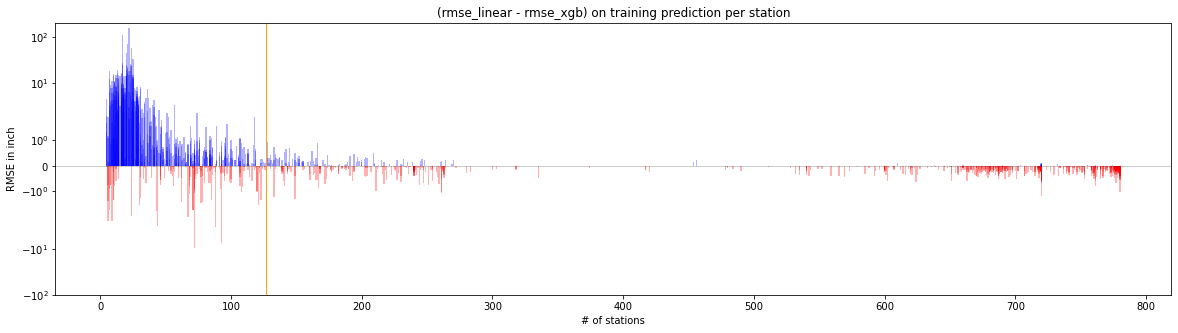

In [175]:
fig, ax = plt.subplots(1, figsize=(20,5))
ax.bar(
    x=df_rmse['n_data'],
    height=df_rmse['diff'],
    width=1,
    color=['b' if item >= 0 else 'r' for item in df_rmse['diff']],
    alpha=0.3
)


ax.set_ylim((-100, 200))
ax.axhline(y=0, linestyle='-', linewidth=1, color='k', alpha=0.2)
ax.axvline(127, linewidth=1, color='orange')
ax.set_xlabel('# of stations')
ax.set_ylabel('RMSE in inch')
    
ax.set_title("(rmse_linear - rmse_xgb) on training prediction per station")
ax.set(yscale='symlog')
# plt.tight_layout()
print()

## Conclusion: XGB works better for stations with smaller number of samples, and Linear Regression works better for stations with large number of samples.
### Howcome XGB is doing worse than Linear Regressino with large number of samples?
#### 1. Check if it is overfitting

<hr>

In [179]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=False)
num_groups = df_combined['skn'].unique().shape[0]

df_combined['train_prediction_multi_linear'] = np.zeros(df_combined.shape[0])
df_combined['test_prediction_multi_linear'] = np.empty(df_combined.shape[0])
df_combined['test_prediction_multi_linear'][:] = np.nan

for i, (skn, group) in enumerate(df_combined.groupby("skn")):# iterate the group object
    if group.shape[0] < 5: continue
    # sort chronologically
    # enforce chrono split
    group.sort_values(by=["year", "month"], inplace=True)

    X = np.array(group[columns])
    Y = np.array(group["data_in"])

    
    for train_index, test_index in kf.split(X):
        Xtrain, Xtest = X[train_index], X[test_index]
        Ytrain, Ytest = Y[train_index], Y[test_index]
        
        linear_regression = LinearRegression()
        linear_regression.fit(Xtrain, Ytrain)
        
        # get predictions on training data and test data
        yhat_train = linear_regression.predict(Xtrain)
        yhat_test = linear_regression.predict(Xtest)
        
        df_combined['test_prediction_multi_linear'].iloc[group.index[test_index]] = yhat_test
        df_combined['train_prediction_multi_linear'].iloc[group.index[train_index]] += yhat_train * (1.0/n_splits)
    
    print(f"{i}/{num_groups}", end="\r")
print()

1991/1992


In [180]:
rmse_multi_linear_test = mean_squared_error(df_combined.dropna()["data_in"], df_combined.dropna()['test_prediction_multi_linear'], squared=False)
rmse_multi_linear_train = mean_squared_error(df_combined.dropna()["data_in"], df_combined.dropna()['train_prediction_multi_linear'], squared=False)

print("result on linear regression")
print("RMSE on training prediction: {:.3f}".format(rmse_multi_linear_train))
print("RMSE on test prediction: {:.3f}".format(rmse_multi_linear_test))

result on linear regression
RMSE on training prediction: 3.848
RMSE on test prediction: 4.098


In [182]:
xgboost = XGBRegressor(
    n_estimators=280,
    learning_rate=0.1,
    max_depth=9,
    verbosity=0
)

start = time.time()

predictions = np.zeros(df_combined.shape[0])
data_in = []
mean_training_prediction = np.zeros(df_combined.shape[0])

df_combined['test_prediction_single_xgb'] = np.zeros(df_combined.shape[0])
df_combined['train_prediction_single_xgb'] = np.zeros(df_combined.shape[0])


for fold in range(n_folds):
    print(f"Running the {fold}-th fold")
    df_train = df_combined[df_combined['fold'] != fold]
    df_test = df_combined[df_combined['fold'] == fold]
    
    Xtrain = np.array(df_train[columns])
    Ytrain = np.array(df_train["data_in"])
    
    Xtest = np.array(df_test[columns])
    Ytest = np.array(df_test["data_in"])
    
    xgboost.fit(Xtrain, Ytrain)
    
    yhat = xgboost.predict(Xtest)

    df_combined['test_prediction_single_xgb'].iloc[df_test.index] = xgboost.predict(Xtest)
    df_combined['train_prediction_single_xgb'].iloc[df_train.index] += xgboost.predict(Xtrain) * (1.0/n_folds)
    
end = time.time()

print(end - start)

Running the 0-th fold
Running the 1-th fold
Running the 2-th fold
Running the 3-th fold
Running the 4-th fold
248.72357058525085


In [183]:
rmse_single_xgb_test = mean_squared_error(df_combined["data_in"], df_combined['test_prediction_single_xgb'], squared=False)
rmse_single_xgb_train = mean_squared_error(df_combined["data_in"], df_combined['train_prediction_single_xgb'], squared=False)

print("result on xgboost")
print("RMSE on training prediction: {:.3f}".format(rmse_single_xgb_train))
print("RMSE on test prediction: {:.3f}".format(rmse_single_xgb_test))

result on xgboost
RMSE on training prediction: 2.761
RMSE on test prediction: 3.998


In [185]:
# load the file, update, and save
df_result = pd.read_csv(f"{BASE_DIR}/SiteSpecific/result.csv")
df_result = pd.merge(
    left=df_result,
    right=df_combined[['train_prediction_multi_linear', 'skn', 'year', 'month']],
    left_on=['skn', 'year', 'month'],
    right_on=['skn','year', 'month']
)

df_result = pd.merge(
    left=df_result,
    right=df_combined[['train_prediction_single_xgb', 'skn', 'year', 'month']],
    left_on=['skn', 'year', 'month'],
    right_on=['skn','year', 'month']
)


df_result = pd.merge(
    left=df_result,
    right=df_combined[['test_prediction_multi_linear', 'skn', 'year', 'month']],
    left_on=['skn', 'year', 'month'],
    right_on=['skn','year', 'month']
)

df_result = pd.merge(
    left=df_result,
    right=df_combined[['test_prediction_single_xgb', 'skn', 'year', 'month']],
    left_on=['skn', 'year', 'month'],
    right_on=['skn','year', 'month']
)



In [187]:
df_result.to_csv(f"{BASE_DIR}/SiteSpecific/result.csv", index=False)

<hr><hr>

In [192]:
df_result = pd.read_csv(f"{BASE_DIR}/SiteSpecific/result.csv") # NaN is excluded for stations with too few samples
rmse_multi_linear_test = mean_squared_error(df_result["data_in"], df_result['test_prediction_multi_linear'], squared=False)
rmse_multi_linear_train = mean_squared_error(df_result["data_in"], df_result['train_prediction_multi_linear'], squared=False)

print("result on linear regression")
print("RMSE on training prediction: {:.3f}".format(rmse_multi_linear_train))
print("RMSE on test prediction: {:.3f}".format(rmse_multi_linear_test))

rmse_single_xgb_test = mean_squared_error(df_result["data_in"], df_result['test_prediction_single_xgb'], squared=False)
rmse_single_xgb_train = mean_squared_error(df_result["data_in"], df_result['train_prediction_single_xgb'], squared=False)

print("result on xgboost")
print("RMSE on training prediction: {:.3f}".format(rmse_single_xgb_train))
print("RMSE on test prediction: {:.3f}".format(rmse_single_xgb_test))

result on linear regression
RMSE on training prediction: 3.848
RMSE on test prediction: 4.098
result on xgboost
RMSE on training prediction: 2.761
RMSE on test prediction: 3.998


In [190]:
df_result

,skn,year,month,data_in,fold,prediction_multi_linear,prediction_single_xgb,train_prediction_multi_linear,train_prediction_single_xgb,test_prediction_multi_linear,test_prediction_single_xgb
0,1.00,1948,2,1.330000,0,3.332863,4.308321,2.531375,1.628675,3.332863,4.308321
1,2.00,1948,2,2.780000,0,4.981063,3.766231,3.955305,2.228792,4.981063,3.766231
2,2.20,1948,2,1.210000,0,6.109449,5.522999,4.596828,2.839402,6.109449,5.522999
3,2.25,1948,2,2.317491,0,5.125054,4.977380,3.926767,2.333403,5.125054,4.977380
4,2.26,1948,2,2.516542,0,5.471043,4.390144,4.074112,1.966406,5.471043,4.390144
...,...,...,...,...,...,...,...,...,...,...,...
865438,1117.80,2012,5,3.160000,4,1.872654,4.579039,2.280510,2.870211,1.872654,4.579039
865439,1134.00,2012,5,1.950000,4,1.862825,3.501473,1.674752,1.933455,1.862825,3.501473
865440,1137.00,2012,5,2.330000,4,2.701017,4.532232,2.266417,2.838827,2.701017,4.532232
865441,1145.00,2012,5,1.050000,4,1.403245,2.797606,0.842866,0.949260,1.403245,2.797606


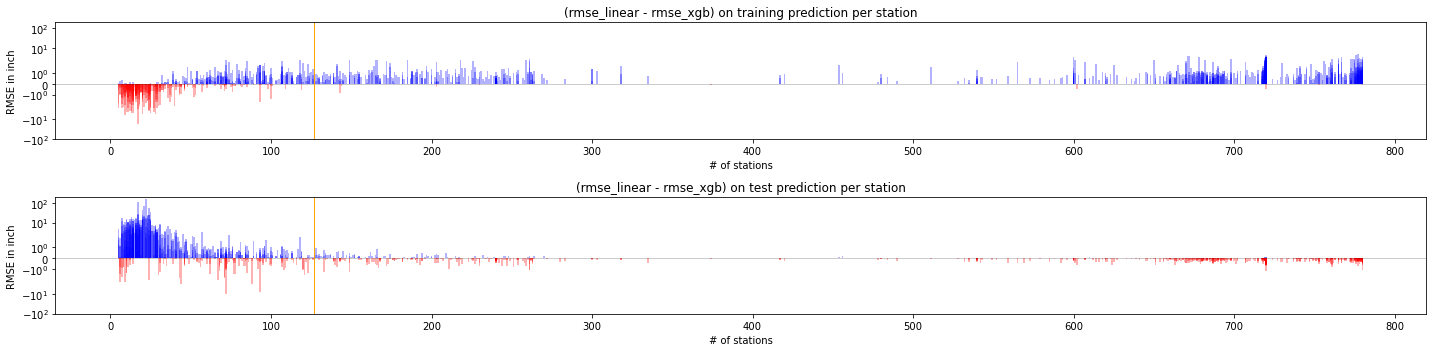

In [25]:
fig, axs = plt.subplots(2, figsize=(20,5))

diff = []
n_data = []
# training prediction
for name, group in df_combined.dropna().groupby(by='skn'):
    rmse_per_station_linear = mean_squared_error(group['data_in'], group['train_prediction_multi_linear'], squared=False)
    rmse_per_station_xgb = mean_squared_error(group['data_in'], group['train_prediction_single_xgb'], squared=False)
    diff.append(rmse_per_station_linear - rmse_per_station_xgb)
    n_data.append(group.shape[0])

axs[0].bar(
    x=n_data,
    # height=np.log(1 + df_comparison_mean['diff']),
    height=diff,
    # height = np.log(1 + np.array(df_result_per_station['diff'])),
    width=1,
    color=['b' if item >= 0 else 'r' for item in diff],
    alpha=0.3
)

diff = []
n_data = []
# test prediction
for name, group in df_combined.dropna().groupby(by='skn'):
    rmse_per_station_linear = mean_squared_error(group['data_in'], group['test_prediction_multi_linear'], squared=False)
    rmse_per_station_xgb = mean_squared_error(group['data_in'], group['test_prediction_single_xgb'], squared=False)
    diff.append(rmse_per_station_linear - rmse_per_station_xgb)
    n_data.append(group.shape[0])
 
axs[1].bar(
    x=n_data,
    # height=np.log(1 + df_comparison_mean['diff']),
    height=diff,
    # height = np.log(1 + np.array(df_result_per_station['diff'])),
    width=1,
    color=['b' if item >= 0 else 'r' for item in diff],
    alpha=0.3
)
for ax in axs:
    # ax.set_ylim((-np.log(abs(np.min(diff))) - 0.5, np.log(np.max(diff)) + 0.5))
    ax.set_ylim((-100, 200))
    ax.axhline(y=0, linestyle='-', linewidth=1, color='k', alpha=0.2)
    ax.axvline(127, linewidth=1, color='orange')
    ax.set_xlabel('# of stations')
    ax.set_ylabel('RMSE in inch')
    
axs[0].set_title("(rmse_linear - rmse_xgb) on training prediction per station")
axs[1].set_title("(rmse_linear - rmse_xgb) on test prediction per station")

axs[0].set(yscale='symlog')
axs[1].set(yscale='symlog')
plt.tight_layout()
print()

# How well can XGB interpolate the locations?
## pt.1 visual purpose only
## pt.2 quantitative result using LOOCV
TODO:
1. choose a specific year and month
2. remove that month from the data => test set, the rest is trainig set
3. make prediction and compare the visual<br>
This model can have training data for all stations, so the input is more permissive than the other experiment that follows.

In [ ]:
df_locations = pd.read_csv(f"{BASE_DIR}/SKNlocations.csv")
df_mock = pd.read_csv(f"{BASE_DIR}/mockdata.csv")

In [73]:
test_year, test_month = 1948, 1

# prepare training data. remove specific (year, month)
df_train_temp = df_combined[(df_combined['year'] != test_year) | (df_combined['month'] != test_month)]

# make sure to drop elevation
Xtrain = np.array(df_train_temp[columns].drop(["data_in"], axis=1))
Ytrain = np.array(df_train_temp.drop("elevation", axis=1)["data_in"])

# train the xgb model
xgboost = XGBRegressor(
    n_estimators=280,
    learning_rate=0.1,
    max_depth=9,
    verbosity=0
)

xgboost.fit(Xtrain, Ytrain)
print()

# prepare test data
Y = np.array(df_mock[[i for i in columns if i != 'data_in']])
yhat = xgboost.predict(Y)
df_mock['prediction_single_xgb'] = yhat

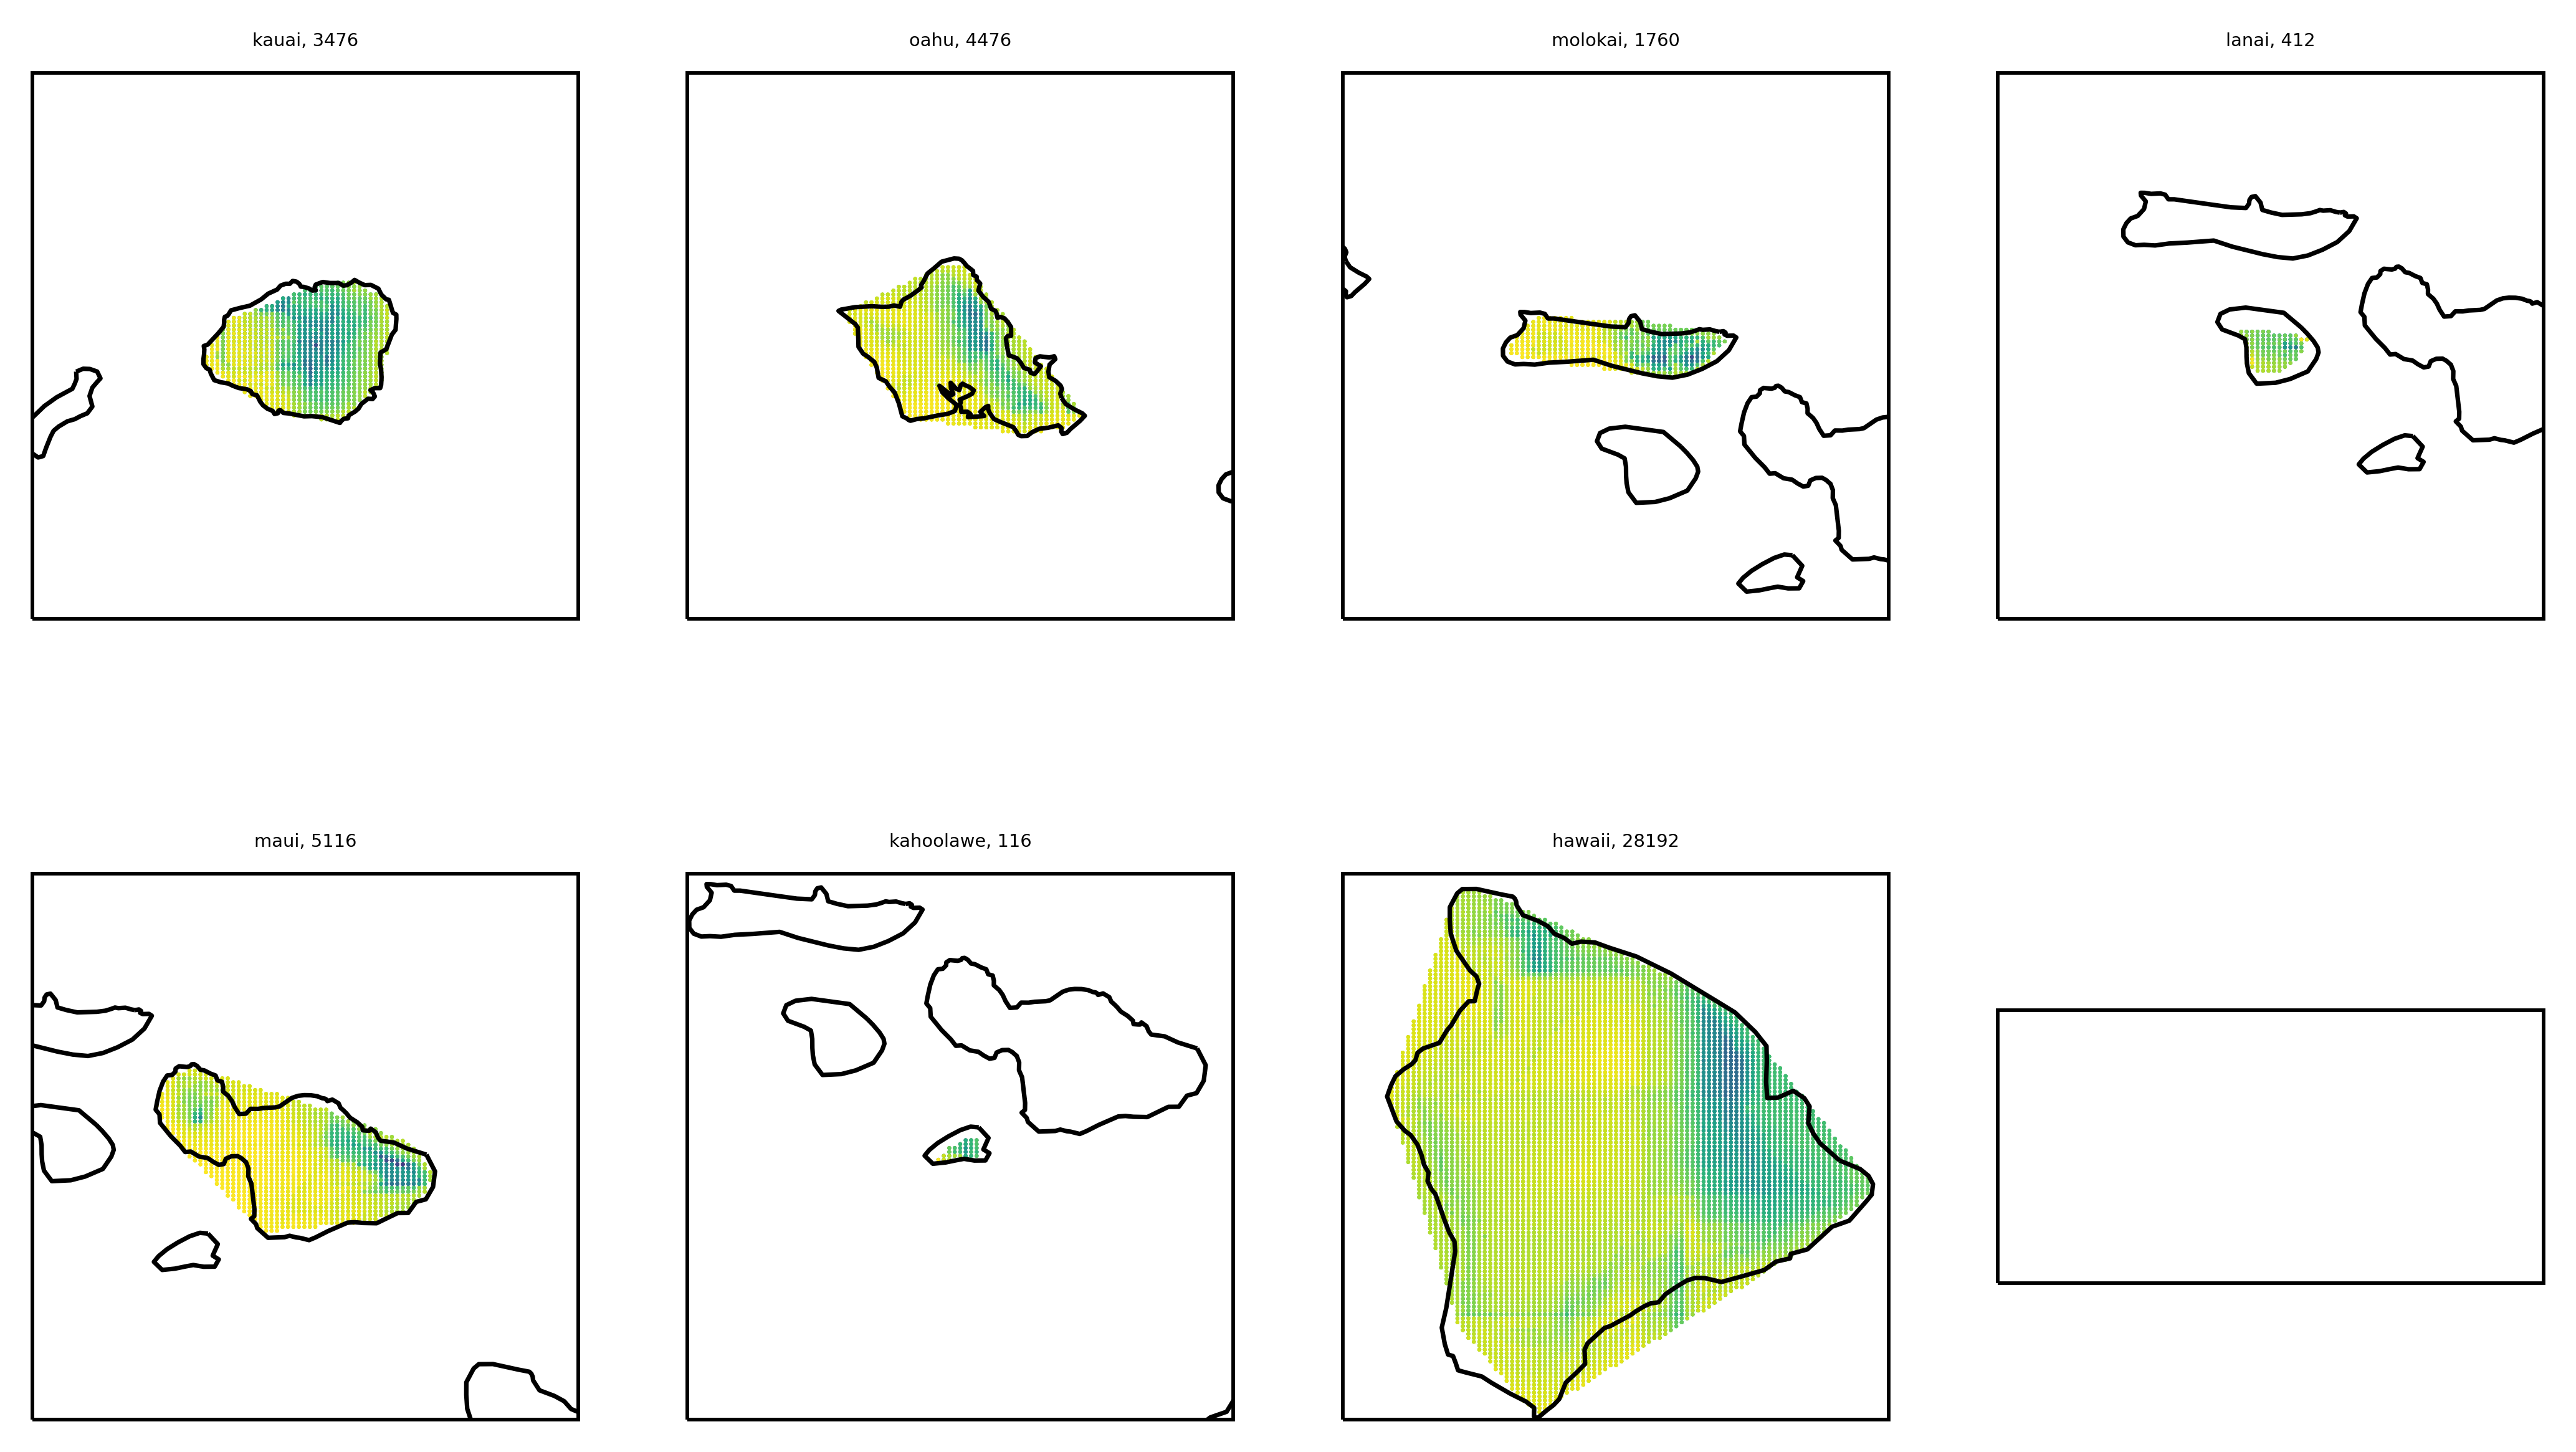

In [75]:
scaler = MinMaxScaler(feature_range=(0,1))

equal_scale = True # whether equalize the map across islands, or use optimal zoom for each island
fig, axs = plt.subplots(
    2, 4, figsize=(10, 6), dpi=520,
    subplot_kw={
        'projection': ccrs.PlateCarree(),
    },
    gridspec_kw={
       # "hspace": 0.1
    }
)

for i, (ax, island_range) in enumerate(zip(axs.flatten(), ISLAND_RANGES)):
    island_range = island_ranges[i]
    df = df_mock[df_mock['island'] == island_range['name']]
    
    ax.set_title(f"{island_range['name']}, {len(df)}", fontsize=4)
    if equal_scale:
        center = (
            (island_range['lon'][1] + island_range['lon'][0]) / 2, 
            (island_range['lat'][1] + island_range['lat'][0]) / 2
        )
        lim = 0.7
        ax.set_xlim((center[0] - lim, center[0] + lim))
        ax.set_ylim((center[1] - lim, center[1] + lim))
    else:
        ax.set_xlim(*island_range['lon'])
        ax.set_ylim(*island_range['lat'])
    ax.scatter(
        df["lon"], df["lat"], s=3,
        facecolor='b', edgecolor='none', alpha=1,
        c=scaler.fit_transform(df["prediction_single_xgb"].to_numpy().reshape(-1,1)) * -1,
        marker='.'
    )
    ax.coastlines(resolution='10m')

In [76]:
test_year, test_month = 2012, 7

# prepare training data. remove specific (year, month)
df_train_temp = df_combined[(df_combined['year'] != test_year) | (df_combined['month'] != test_month)]

# make sure to drop elevation
Xtrain = np.array(df_train_temp[columns].drop(["data_in"], axis=1))
Ytrain = np.array(df_train_temp.drop("elevation", axis=1)["data_in"])

# train the xgb model
xgboost = XGBRegressor(
    n_estimators=280,
    learning_rate=0.1,
    max_depth=9,
    verbosity=0
)

xgboost.fit(Xtrain, Ytrain)
print()

# prepare test data
Y = np.array(df_mock[[i for i in columns if i != 'data_in']])
yhat = xgboost.predict(Y)
df_mock['prediction_single_xgb'] = yhat

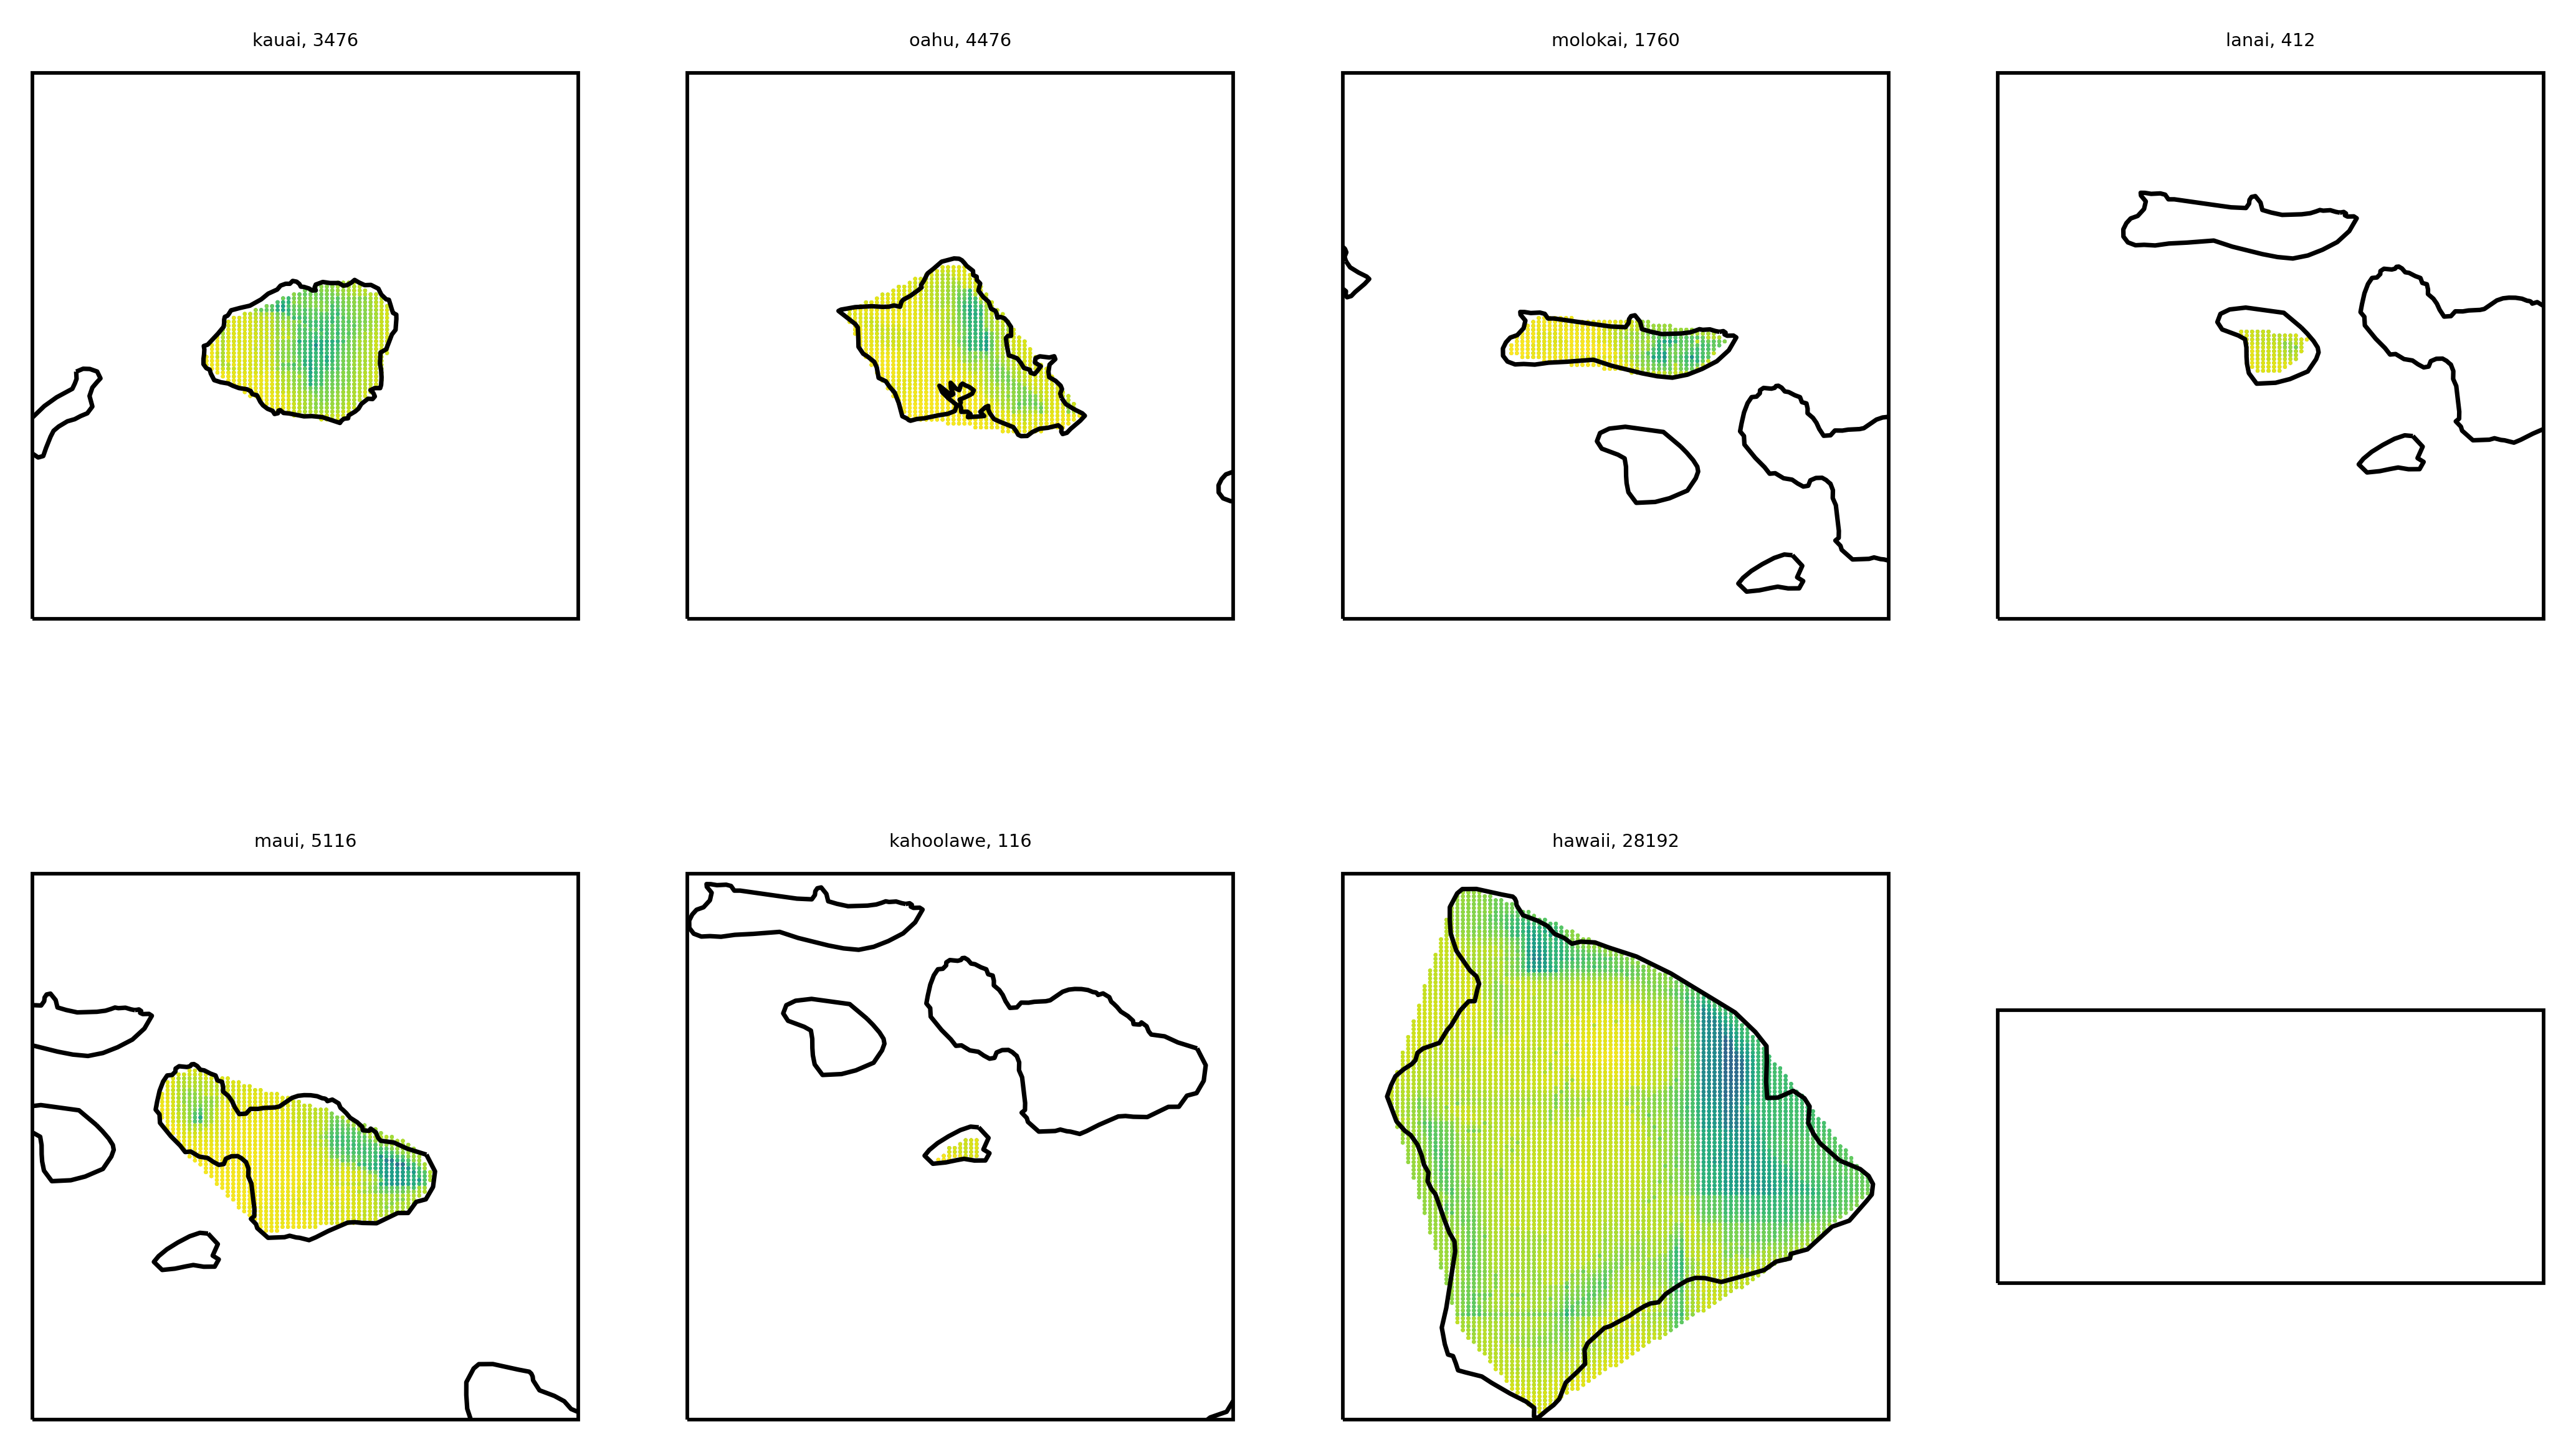

In [77]:
scaler = MinMaxScaler(feature_range=(0,1))

equal_scale = True # whether equalize the map across islands, or use optimal zoom for each island
fig, axs = plt.subplots(
    2, 4, figsize=(10, 6), dpi=520,
    subplot_kw={
        'projection': ccrs.PlateCarree(),
    },
    gridspec_kw={
       # "hspace": 0.1
    }
)

for i, (ax, island_range) in enumerate(zip(axs.flatten(), ISLAND_RANGES)):
    island_range = island_ranges[i]
    df = df_mock[df_mock['island'] == island_range['name']]
    
    ax.set_title(f"{island_range['name']}, {len(df)}", fontsize=4)
    if equal_scale:
        center = (
            (island_range['lon'][1] + island_range['lon'][0]) / 2, 
            (island_range['lat'][1] + island_range['lat'][0]) / 2
        )
        lim = 0.7
        ax.set_xlim((center[0] - lim, center[0] + lim))
        ax.set_ylim((center[1] - lim, center[1] + lim))
    else:
        ax.set_xlim(*island_range['lon'])
        ax.set_ylim(*island_range['lat'])
    ax.scatter(
        df["lon"], df["lat"], s=3,
        facecolor='b', edgecolor='none', alpha=1,
        c=scaler.fit_transform(df["prediction_single_xgb"].to_numpy().reshape(-1,1)) * -1,
        marker='.'
    )
    ax.coastlines(resolution='10m')

In [ ]:
# use (Sin, cos) for month

## Provide quantitative result using LOOCV

<hr>

In [64]:
# pick a station and month on which we want to make prediction
# remove all data that satisfies the above condition
# train on the reduced dataset and make prediction on the extracted dataset
# compare with site-specific linear regression and compare: want to see "the performance is at least as good as linear regression"

In [31]:
# training set preparation
test_year, test_month = 1948, 7
sample_skn = df_combined['skn'].sample(random_state=40).values[0]

df_train_temp = df_combined[
    ((df_combined["year"] != test_year) | (df_combined["month"] != test_month)) &
    (df_combined["skn"] != sample_skn)
]

# we are making prediction on a specific station, on a specific month, hence all & operators
df_test_temp = df_combined[
    ((df_combined["year"] == test_year) & (df_combined["month"] == test_month)) &
    (df_combined["skn"] == sample_skn)
]

In [32]:
Xtrain = np.array(df_train_temp[columns].drop("data_in", axis=1))
Ytrain = np.array(df_train_temp["data_in"])

Xtest = np.array(df_test_temp[columns].drop("data_in", axis=1))
Ytest = np.array(df_test_temp["data_in"])

xgboost = XGBRegressor(
    n_estimators=280,
    learning_rate=0.1,
    max_depth=9,
    verbosity=0
)
xgboost.fit(Xtrain, Ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=9, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=170, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=0)

In [33]:
yhat = xgboost.predict(Xtest)
mean_squared_error(Ytest, yhat, squared=False)

1.3520503330230715

In [34]:
# linear regression
df_train_linear = df_combined[
    ((df_combined["year"] != test_year) | (df_combined["month"] != test_month)) &
    (df_combined["skn"] == sample_skn) 
]

Xtrain = df_train_linear[columns].drop("data_in", axis=1)
Ytrain = df_train_linear["data_in"]
# ytest is the same

linear_regression = LinearRegression()
linear_regression.fit(Xtrain, Ytrain)
yhat = linear_regression.predict(Xtest)
mean_squared_error(Ytest, yhat, squared=False)

0.1642843805837222